# 5.1 Generalization


train_images shape:	(60000, 784)
test_images shape:	(10000, 28, 28)


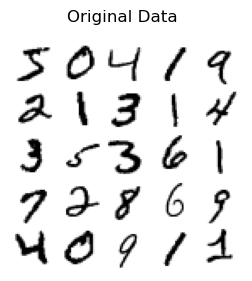

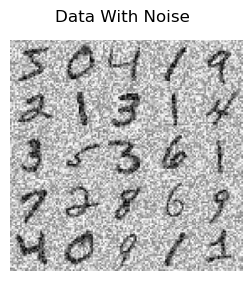

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data(path="mnist.npz")
)

train_images = train_images.reshape(
    train_images.shape[0], train_images.shape[1] * train_images.shape[2]
)
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1
)

train_images_with_noise = np.add(
    train_images, np.random.random((len(train_images), 784))
)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1
)

print(
    f"train_images shape:\t{train_images.shape}\ntest_images shape:\t{test_images.shape}"
)


def plot_digit(image_array):
    image = image_array.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


plt.figure(figsize=(3, 3))
for idx, image_data in enumerate(train_images[:25]):
    plt.subplot(5, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Original Data")
plt.show()

plt.figure(figsize=(3, 3))
for idx, image_data in enumerate(train_images_with_noise[:25]):
    plt.subplot(5, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Data With Noise")
plt.show()

## 5.1.1 Underfitting and Overfitting

Noisy features are prone to overfitting.

### Helper function


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.facecolor"] = "darkgray"
mpl.rcParams["axes.facecolor"] = "white"


def fit_and_plot_results(
    model,
    x_train,
    y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="",
    loss_only=False,
    axes=None,
    start_at_idx=0,
):
    history = model.fit(
        x_train,
        y_train,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=val_ratio,
        verbose=verbose,
    )
    history_dct = history.history

    loss_values = history_dct["loss"][start_at_idx:]
    val_loss_values = history_dct["val_loss"][start_at_idx:]
    acc = history_dct["accuracy"][start_at_idx:]
    val_acc = history_dct["val_accuracy"][start_at_idx:]
    epochs = range(1, len(loss_values) + 1)

    # First subplot (Training and validation loss)
    axes[0].plot(epochs, loss_values, "b--", label="Training Loss")
    axes[0].plot(epochs, val_loss_values, "r", label="Validation Loss")
    axes[0].set_title(f"Loss - {title}")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    if not loss_only:
        # Second subplot (Training and validation accuracy)
        axes[1].plot(epochs, acc, "b--", label="Training Accuracy")
        axes[1].plot(epochs, val_acc, "r", label="Validation Accuracy")
        axes[1].set_title(f"Accuracy - {title}")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()

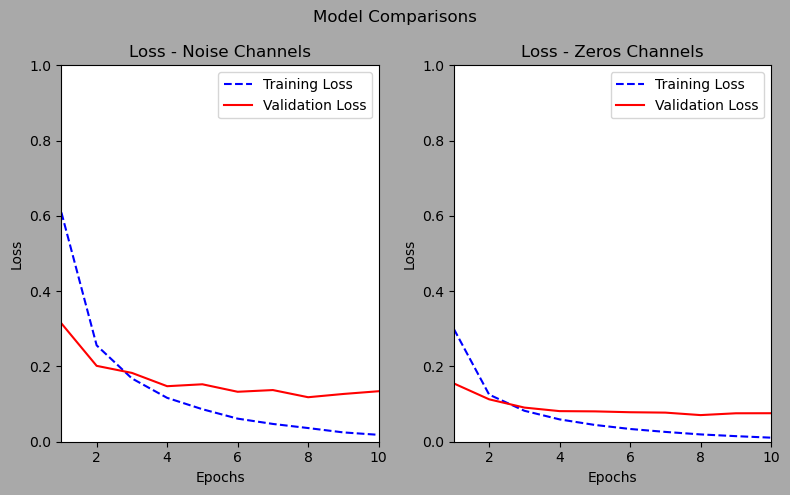

In [3]:
import keras
from keras import layers


def get_model():
    l1 = layers.Dense(512, activation="relu")
    output_layer = layers.Dense(10, activation="softmax")

    model = keras.Sequential()
    model.add(l1)
    model.add(output_layer)
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Model Comparisons")

# Model 1: Noise channels
fit_and_plot_results(
    model=get_model(),
    x_train=train_images_with_noise_channels,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Noise Channels",
    loss_only=True,
    axes=[axs[0]],
)

# Model 2: Zeros channels
fit_and_plot_results(
    model=get_model(),
    x_train=train_images_with_zeros_channels,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Zeros Channels",
    loss_only=True,
    axes=[axs[1]],
)

# Get the x and y limits for all axes
xlims = [ax.get_xlim() for ax in fig.axes]
ylims = [ax.get_ylim() for ax in fig.axes]

# Calculate the minimum and maximum limits across all axes
xmin, xmax = round(min(x[0] for x in xlims)), round(max(x[1] for x in xlims))
ymin, ymax = round(min(y[0] for y in ylims)), round(max(y[1] for y in ylims))

# Set the limits for each axis
for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()

# 5.3 Improving Model Fit

## 5.3.1 Tuning Key Gradient Descent Parameters

If model doesn't get started - or stalls too early, we can overcome it by changing gradient descent parameters. This is always true.
If this happens try modifying learning rate or increasing batch size.


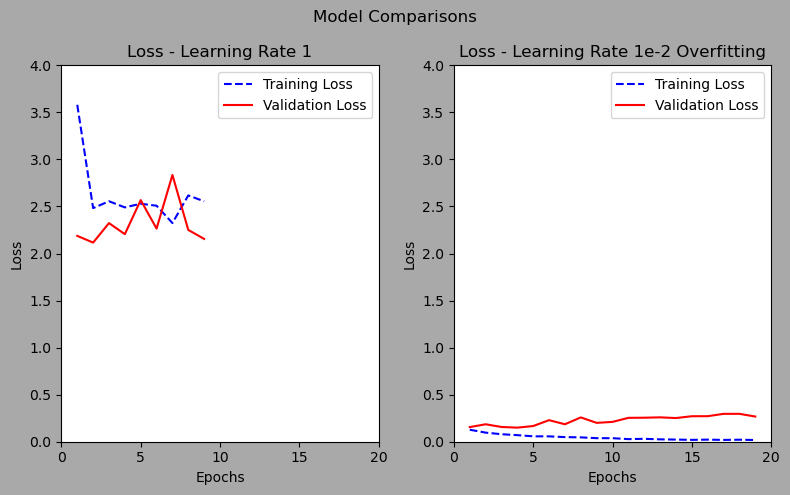

In [4]:
def get_model_rms_prop_change(learning_rate: float):
    model = keras.Sequential(
        [layers.Dense(512, activation="relu"), layers.Dense(10, activation="softmax")]
    )
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Model Comparisons")

# Learning rate 1.0
fit_and_plot_results(
    model=get_model_rms_prop_change(learning_rate=1.0),
    x_train=train_images,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Learning Rate 1",
    loss_only=True,
    axes=[axs[0]],
    start_at_idx=1,
)

# Learning rate 1e-2 with overfitting
fit_and_plot_results(
    model=get_model_rms_prop_change(learning_rate=1e-2),
    x_train=train_images,
    y_train=train_labels,
    n_epochs=20,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Learning Rate 1e-2 Overfitting",
    loss_only=True,
    axes=[axs[1]],
    start_at_idx=1,
)

# Get the x and y limits for all axes
xlims = [ax.get_xlim() for ax in fig.axes]
ylims = [ax.get_ylim() for ax in fig.axes]

# Calculate the minimum and maximum limits across all axes
xmin, xmax = round(min(x[0] for x in xlims)), round(max(x[1] for x in xlims))
ymin, ymax = round(min(y[0] for y in ylims)), round(max(y[1] for y in ylims))

# Set the limits for each axis
for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()

# 5.4 Improving Generalization
This cell is repeated from ch4

In [5]:
from keras import datasets as kds

(train_data, train_labels), (test_data, test_labels) = kds.imdb.load_data(
    num_words=10_000
)

word_idx = kds.imdb.get_word_index()
reverse_word_idx = dict([(v, k) for (k, v) in word_idx.items()])
# Indices are offset by 4 because first 3 indices are reserved for "padding", "start of sequence", and "unknown"
decoded_review = " ".join([reverse_word_idx.get(i - 3, "?") for i in train_data[0]])
print(decoded_review)


def vectorize_sequences(sequences, dimension=10_000):
    results = np.zeros(shape=(len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    return results


# vectorize reviews
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# vectorize labels
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## 5.4.1 Dataset curation

Skip for now.

## 5.4.2 Feature Engineering - skip

Skip for now.

## 5.4.3 Early Stopping - covered later

Skip for now.

## 5.4.4 Regularizing Models

### 5.4.4.1 Reduce Network Size

Smaller models tend to overfit less.

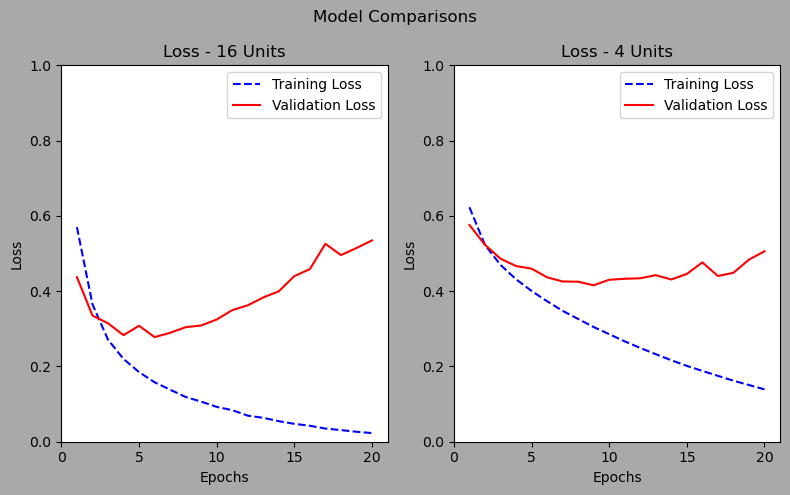

In [6]:
def make_standard_model():
    model = keras.Sequential(
        [
            layers.Dense(16, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model


model4 = keras.Sequential(
    [
        layers.Dense(4, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Model Comparisons")

# 16 Units
fit_and_plot_results(
    model=make_standard_model(),
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="16 Units",
    loss_only=True,
    axes=[axs[0]],
    start_at_idx=0,
)

# 4 Units
fit_and_plot_results(
    model=model4,
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="4 Units",
    loss_only=True,
    axes=[axs[1]],
    start_at_idx=0,
)

# Get the x and y limits for all axes
xlims = [ax.get_xlim() for ax in fig.axes]
ylims = [ax.get_ylim() for ax in fig.axes]

# Calculate the minimum and maximum limits across all axes
xmin, xmax = round(min(x[0] for x in xlims)), round(max(x[1] for x in xlims))
ymin, ymax = round(min(y[0] for y in ylims)), round(max(y[1] for y in ylims))

# Set the limits for each axis
for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()

del model4

### 5.4.4.2 Adding Weight Regularization
Impede model ability to find perfect fit.
#### Lasso Regression ($ L_1 $ Regularization)
- $L_1$ regularization adds a penalty equal to the absolute value of the magnitude of the coefficients.
- It can result in sparse models with few coefficients; some coefficients can become exactly zero, effectively performing feature selection.

$$ J(\theta) = \text{Cost}(\theta) + \lambda \sum_{i=1}^{n} |\theta_i| $$

#### Ridge Regression ($L_2$ Regularization)
- $L_2$ regularization adds a penalty equal to the square of the magnitude of the coefficients.
- It tends to distribute the error among all the terms, resulting in smaller but non-zero coefficients.
- It helps prevent overfitting by penalizing large coefficients, making the model more generalizable.

$$ J(\theta) = \text{Cost}(\theta) + \lambda \sum_{i=1}^{n} \theta_i^2 $$

where:
- $\text{Cost}(\theta)$ is the original cost function (e.g., mean squared error in linear regression).
- $\lambda$ is the regularization parameter that controls the strength of regularization.
- $\theta_i$ are the model parameters.


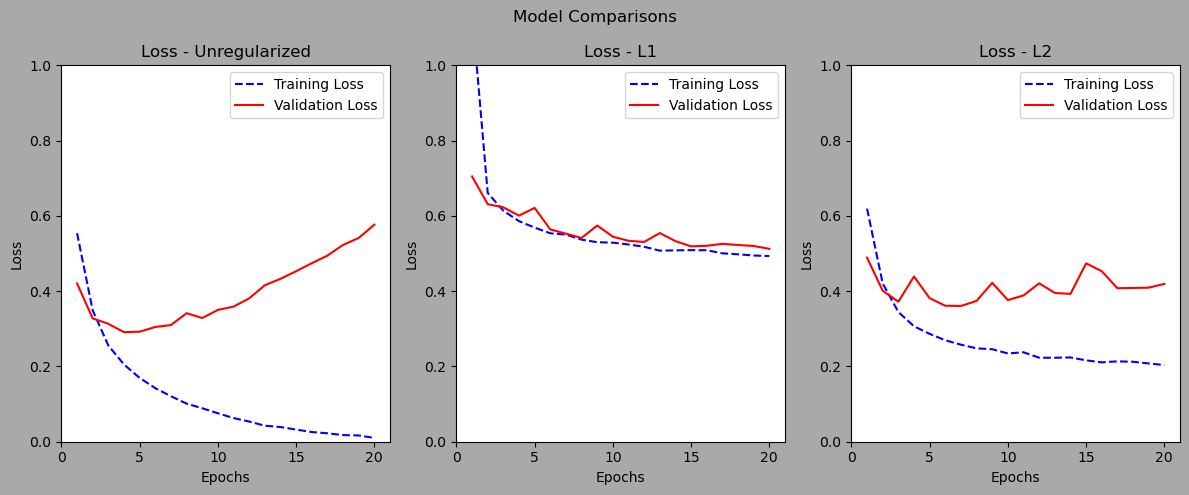

In [7]:
from keras import regularizers

model_l1 = keras.Sequential(
    [
        layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
        layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model_l1.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model_l2 = keras.Sequential(
    [
        layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model_l2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Model Comparisons")


# 16 Units
fit_and_plot_results(
    model=make_standard_model(),
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="Unregularized",
    loss_only=True,
    axes=[axs[0]],
    start_at_idx=0,
)

# L1
fit_and_plot_results(
    model=model_l1,
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="L1",
    loss_only=True,
    axes=[axs[1]],
    start_at_idx=0,
)

# L2
fit_and_plot_results(
    model=model_l2,
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="L2",
    loss_only=True,
    axes=[axs[2]],
    start_at_idx=0,
)


# Get the x and y limits for all axes
xlims = [ax.get_xlim() for ax in fig.axes]
ylims = [ax.get_ylim() for ax in fig.axes]

# Calculate the minimum and maximum limits across all axes
xmin, xmax = round(min(x[0] for x in xlims)), round(max(x[1] for x in xlims))
ymin, ymax = round(min(y[0] for y in ylims)), round(max(y[1] for y in ylims))

# Set the limits for each axis
for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()

del model_l1, model_l2

### 5.4.4.3 Dropout
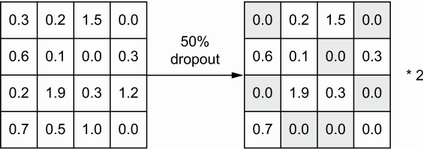
Set a fraction of outputs from a layer to 0.

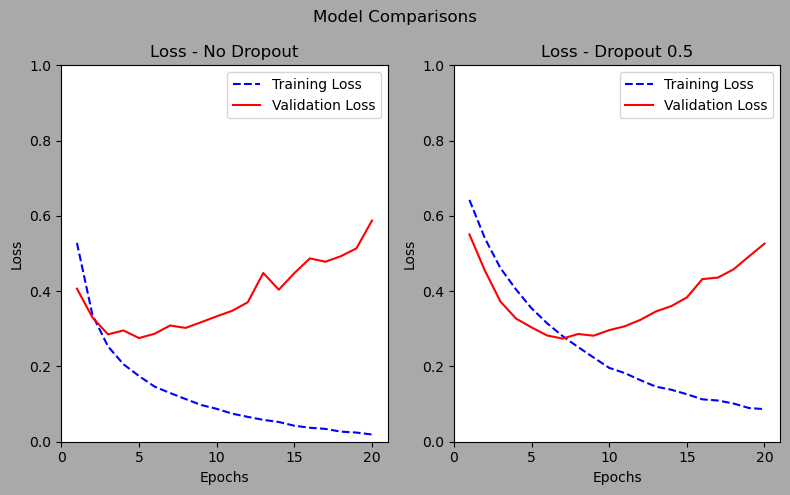

In [9]:
model_dropout = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model_dropout.compile(
    optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]
)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Model Comparisons")

# 16 Units
fit_and_plot_results(
    model=make_standard_model(),
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="No Dropout",
    loss_only=True,
    axes=[axs[0]],
    start_at_idx=0,
)

# 4 Units
fit_and_plot_results(
    model=model_dropout,
    x_train=x_train,
    y_train=y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="Dropout 0.5",
    loss_only=True,
    axes=[axs[1]],
    start_at_idx=0,
)

# Get the x and y limits for all axes
xlims = [ax.get_xlim() for ax in fig.axes]
ylims = [ax.get_ylim() for ax in fig.axes]

# Calculate the minimum and maximum limits across all axes
xmin, xmax = round(min(x[0] for x in xlims)), round(max(x[1] for x in xlims))
ymin, ymax = round(min(y[0] for y in ylims)), round(max(y[1] for y in ylims))

# Set the limits for each axis
for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()